# Importing Libraries

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Initializing parameters

In [2]:
# True parameters
true_lambda0 = 0.5   # Parent decay rate
true_lambda1 = 0.35   # Daughter 1 decay rate
true_lambda2 = 0.15   # Daughter 2 decay rate
true_N0 = 1000       # Initial parent nuclei
sigma_noise = 20     # Observation noise

# Solving the ODE

## Solving the ODE using ```solve_ivp```

The ODE is:
\begin{equation*}
    \frac{dN_{\alpha}}{dt}=\lambda N(t)=\lambda N_0e^{-\lambda t}
\end{equation*}


In [3]:
# ODE system
def decay_system(t, y, lambda0, lambda1, lambda2):
    N0, N1, N2, N3 = y
    dN0dt = -lambda0 * N0
    dN1dt = lambda0 * N0 - lambda1 * N1
    dN2dt = lambda1 * N1 - lambda2 * N2
    dN3dt = lambda2 * N2
    return [dN0dt, dN1dt, dN2dt, dN3dt]

# Generate synthetic data
t_obs = np.linspace(0, 50, 150)
sol = solve_ivp(
    decay_system,
    [0, 50],
    [true_N0, 0, 0, 0],
    args=(true_lambda0, true_lambda1, true_lambda2),
    t_eval=t_obs
)
N_true = sol.y

# Add noise
np.random.seed(42)
N_obs = N_true + np.random.normal(0, sigma_noise, N_true.shape)

## Plotting Results

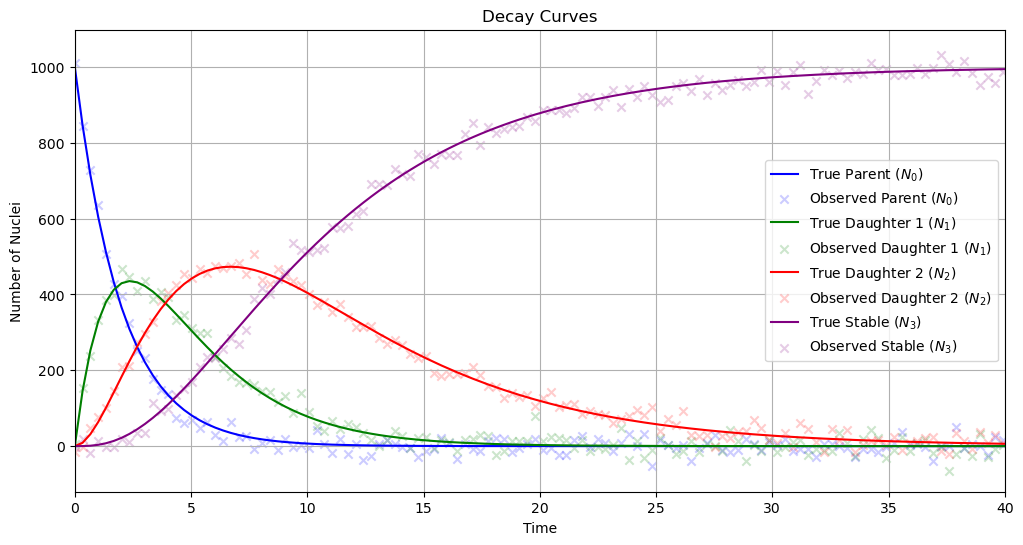

In [5]:
# Plot true curves and noisy data
labels = ['Parent ($N_0$)', 'Daughter 1 ($N_1$)', 'Daughter 2 ($N_2$)', 'Stable ($N_3$)']
colors = ['blue', 'green', 'red', 'purple']
plt.figure(figsize=(12, 6))
for i, (label, color) in enumerate(zip(labels, colors)):
    plt.plot(t_obs, N_true[i], '-', color=color, label=f'True {label}')
    plt.scatter(t_obs, N_obs[i], color=color, marker='x',alpha=0.2, label=f'Observed {label}')
plt.xlabel('Time')
plt.ylabel('Number of Nuclei')
plt.xlim(0,40)
plt.legend()
plt.title('Decay Curves')
plt.grid()
plt.show()

## Solving the ODE using Markov Chain Monte Carlo (MCMC)

### Changing the ODE system to much the data format that is required for the ```Pymc``` library.

### Sampling from the posterior distributions after ```1000``` iterations of mcmc.

In [ ]:
import pytensor.tensor as pt
def decay_system(y, t, p):
    # Explicit indexing for PyTensor compatibility
    N0 = y[0]
    N1 = y[1]
    N2 = y[2]
    N3 = y[3]
    lambda0 = p[0]
    lambda1 = p[1]
    lambda2 = p[2]
    
    dN0dt = -lambda0 * N0
    dN1dt = lambda0 * N0 - lambda1 * N1
    dN2dt = lambda1 * N1 - lambda2 * N2
    dN3dt = lambda2 * N2
    
    return pt.stack([dN0dt, dN1dt, dN2dt, dN3dt])


with pm.Model() as model:
    # Priors
    lambda0 = pm.Gamma('lambda0', alpha=1, beta=1)
    lambda1 = pm.Gamma('lambda1', alpha=1, beta=1)
    lambda2 = pm.Gamma('lambda2', alpha=1, beta=1)
    N0_init = pm.Lognormal('N0_init', mu=np.log(1000), sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=20)
    
    # ODE solution - critical working version
    def rhs(y, t, p):
        return decay_system(y, t, p)
    
    ode_solution = pm.ode.DifferentialEquation(
        func=rhs,
        times=t_obs,
        n_states=4,
        n_theta=3,
    )
    
    N_theo = ode_solution(y0=[N0_init, 0, 0, 0], theta=[lambda0, lambda1, lambda2])
    
    # Likelihoods
    for i, label in enumerate(['N0', 'N1', 'N2', 'N3']):
        pm.Normal(f'obs_{label}', mu=N_theo[:, i], sigma=sigma, observed=N_obs[i])
    
    # Sampling
    trace = pm.sample(1000, tune=500, target_accept=0.9, cores=1)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lambda0, lambda1, lambda2, N0_init, sigma]


/home/burpsploit/.conda/envs/pymc/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/burpsploit/.conda/envs/pymc/lib/python3.13/site-packages/pymc/ode/ode.py:133: ODEintWarning: Excess accuracy 
requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4096324545299D-04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4096324545299D-04   r2 =                  NaN


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 924 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


### Extraction of the parameters ($\lambda$, $N_0$)

### Solving again the ODE using the solve_ivp vut for the parameters we have the posterior distributions.



In [17]:
# Analysis and plotting
t_plot = np.linspace(0, 40, 100)

# Extract parameter values from trace (convert to numpy arrays)
lambda0_val = np.mean(trace.posterior['lambda0'].values)
lambda1_val = np.mean(trace.posterior['lambda1'].values)
lambda2_val = np.mean(trace.posterior['lambda2'].values)
N0_init_val = np.mean(trace.posterior['N0_init'].values)

# Use regular numpy operations for plotting
def decay_system_numpy(y, t, p):
    N0, N1, N2, N3 = y
    lambda0, lambda1, lambda2 = p
    dN0dt = -lambda0 * N0
    dN1dt = lambda0 * N0 - lambda1 * N1
    dN2dt = lambda1 * N1 - lambda2 * N2
    dN3dt = lambda2 * N2
    return np.array([dN0dt, dN1dt, dN2dt, dN3dt])

sol_est = solve_ivp(
    lambda t, y: decay_system_numpy(y, t, [lambda0_val, lambda1_val, lambda2_val]),
    [0, 40],
    [N0_init_val, 0, 0, 0],
    t_eval=t_plot
)

## Plotting

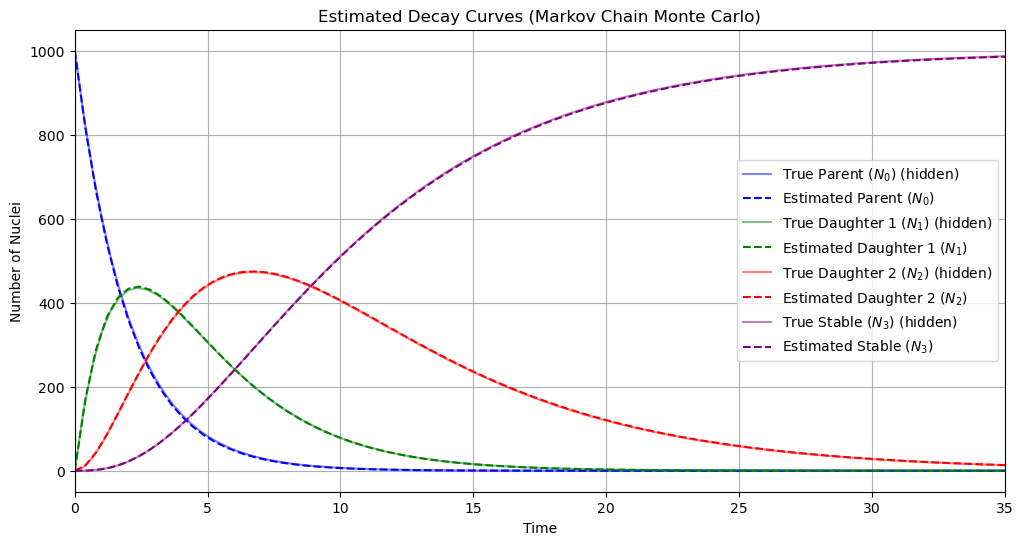

In [20]:
plt.figure(figsize=(12, 6))
for i, (label, color) in enumerate(zip(labels, colors)):
    plt.plot(t_obs, N_true[i], '-', color=color, alpha=0.5, label=f'True {label} (hidden)')
    plt.plot(t_plot, sol_est.y[i], '--', color=color, label=f'Estimated {label}')
plt.xlabel('Time')
plt.ylabel('Number of Nuclei')
plt.xlim(0,35)
plt.legend()
plt.title('Estimated Decay Curves (Markov Chain Monte Carlo)')
plt.grid()
plt.show()